# Longitudinal Pump

The Hamiltonian is
$$
H_\text{long} = \frac{p^2}{2m} + V_\text{ext}(x) - \hbar \Delta_\text{c} a^\dagger a + \hbar \eta (a + a^\dagger) + \hbar U_0 \cos(kx)^2,
$$
where $\Delta_\text{c} = \omega_\text{l} - \omega_\text{c}$, $\eta$ is the pump strength and $U_0$ is the depth of the potential. Note that because $H_\text{long} \propto \cos(kx)^2$, the Hamiltonian is $\lambda / 2$-periodic.

In [1]:
using QuantumOptics, PyPlot, Printf, LinearAlgebra, PyCall

We choose a maximum number of photons of $N_\text{cutoff}=16$. If we choose $k=2\pi$, then $\lambda=1$.

In [9]:
# Define Parameters
N_cutoff = 64
xmin = 0
xmax = 1
Nsteps = 64

k = 2*π
ωr = 1

Δc = -10 * ωr
U0 = -1 * ωr;

In [10]:
# Bases
b_position = PositionBasis(xmin, xmax, Nsteps)
b_fock = FockBasis(N_cutoff)

# Operators for atom
p = momentum(b_position)

# Operators for cavity
a = destroy(b_fock) ⊗ one(b_position)
ad = dagger(a);

In [11]:
# Hamiltonian and calculate states
potential = x -> U0*cos(k*x)^2
H_int = (one(b_fock) ⊗ potentialoperator(b_position, potential))*ad*a
H_kin = (one(b_fock) ⊗ p^2) / k^2
H_cavity = -Δc*ad*a

function H(η)
    H_kin + dense(H_int) + H_cavity + η*(a + ad)
end;

In [12]:
# Plot distributions for first three states

rc("text", usetex=true)
rc("text.latex", preamble= "\\usepackage{amsmath}")
rc("font", family="serif")

η = 30 * ωr
E, ψ_states = eigenstates((H(η) + dagger(H(η)))/2, 3);

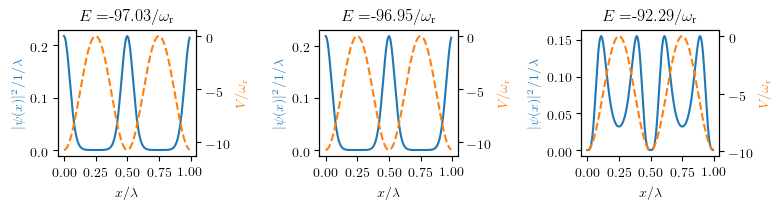

In [16]:
pygui(false)
N = real(expect(ad*a, ψ_states[1]))

xpoints = samplepoints(b_position)

fig = figure(figsize=(8, 2.2))
host_1 = fig.add_subplot(131)
host_2 = fig.add_subplot(132)
host_3 = fig.add_subplot(133)
hosts = [host_1, host_2, host_3]

for i in 1:3
    host = hosts[i]
    par1 = host.twinx()
    
    pos_dense = ptrace(ψ_states[i], 1)
    density = diag(pos_dense.data)
    ψ_sqr = abs2.(density)
    normalize!(ψ_sqr)
    ada_exp = expect(ad*a, ψ_states[i])
    pot = @. U0*cos(k*xpoints)^2*real(ada_exp)
    
#     host.set_ylim(-0.0004, 0.0078)
#     par1.set_ylim(-15.590715, 0.829001)
#     host.set_xlim(.25, .75)
#     par1.set_xlim(.25, .75)
    host.set_xticks([0, .25, .5, .75, 1])
    host.plot(xpoints, ψ_sqr, "C0")
    par1.plot(xpoints, pot, "C1", linestyle="--")
    
    host.set_xlabel(L"x / \lambda")
    host.set_ylabel(L"|\psi(x)|^2 / 1/\lambda")
    par1.set_ylabel(L"V / \omega_\text{r}")
    host.yaxis.label.set_color("C0")
    par1.yaxis.label.set_color("C1")
    
#     par1.set_ylim(-7.370032, 0.350954)
    # Boundaries
#     println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
#     println("par1.set_ylim(" *@sprintf("%.6f", par1.get_ylim()[1]) *", " *@sprintf("%.6f", par1.get_ylim()[2]) *")")
    
    title(L"E=" * @sprintf("%.2f", E[i]) * L"/ \omega_\text{r}")
end

tight_layout(rect=[0, 0, 1, 1])

Actually, we'd only have to plot from 0 to 0.5 since the Hamiltonian is $\lambda / 2$-periodic. However, we plot form 0 to 1 so that the longitudinal and transversal plots have the same boundaries. We can see that the ground state and the first excited state have the same energy and thus are degenerate states.

In [24]:
# Calculate momentum

b_momentum = MomentumBasis(b_position)
Tpx = transform(b_momentum, b_position)

η_arr = [0, 10, 20, 40] .* ωr
p_arr = []

for i in 1:size(η_arr)[1]
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i])))/2, 1);
    pos_dense = ptrace(ψ_states[1], 1)
    states_p = Tpx * pos_dense
    momentum = abs.(diag(states_p.data))
    push!(p_arr, momentum)
end

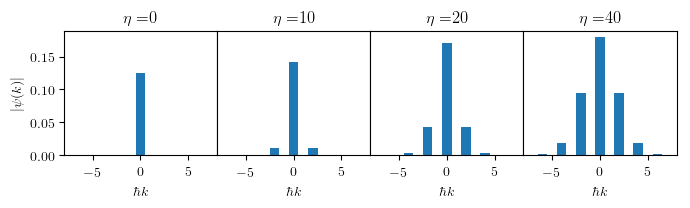

In [27]:
# Plot momentum

rc("text", usetex=true)
rc("font", family="serif")
pygui(false)

coeff_arr = [-Nsteps/2:1:Nsteps/2-1;]

fig = figure(figsize=(7,2.1875))
for i in 1:size(η_arr)[1]
    plt_index = 100 + size(η_arr)[1]*10 + i
    host = fig.add_subplot(plt_index)
    
    host.bar(coeff_arr, p_arr[i], width=1)
    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
    host.set_ylim(0.0000, 0.19)
    host.set_xlim(-8, 8)
    host.set_xlabel(L"\hbar k")
    if i == 1
        host.set_ylabel(L"|\psi(k)|")
    else
        yticks([], [])
    end
#     println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
end

# tight_layout(rect=[0, 0, 1.5, 1.6])
tight_layout()
subplots_adjust(hspace=0, wspace=0);

Between occupied momenta, there's always a gap which is not the case with the transversal pump.

In [5]:
# Calculate parameters for photon number plot

η_arr = [0:0.5:15;] .* ωr
X = [0:1:N_cutoff;]
probab_arr = []
N_arr = []
σ_sqr_arr = []

for i in 1:size(η_arr)[1]
    _, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i])))/2, 1)
    photon_dense = ptrace(ψ_states[1], 2)
    
    probab = diag(photon_dense.data)
    N = real(expect(ad*a, ψ_states[1]))
    σ_sqr = real(sum(probab .* X.^2) - N^2)
    
    push!(probab_arr, probab)
    push!(N_arr, N)
    push!(σ_sqr_arr, σ_sqr)
end

In [10]:
for i in N_arr
    print("$(i)" * ", ")
end

3.029836092048697e-28, 0.0027774977107312524, 0.011111208272029716, 0.025004784694994855, 0.04446431752945493, 0.06949833740898453, 0.100117817107542, 0.13633617159726308, 0.1781692541635204, 0.22563534620560471, 0.2787551379383685, 0.3375516968253934, 0.4020504202368414, 0.4722789685592864, 0.5482671748205172, 0.6300469268648772, 0.7176520182613177, 0.8111179644884796, 0.9104817815537585, 1.0157817250989631, 1.1270569892406077, 1.244347365888264, 1.3676928670552713, 1.4971333146670112, 1.6327079044954007, 1.7744547529840462, 1.9224104377250664, 2.0766095440385888, 2.2370842313124983, 2.4038638333212123, 2.576974506532628, 

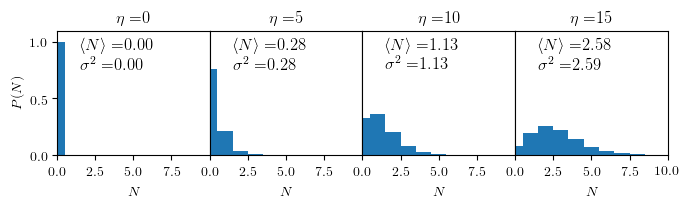

In [12]:
# Plot photon number
using PyCall

rc("text", usetex=true)
rc("font", family="serif")
pygui(false)

displace = [0.15, 0.15, 0.15, 0.15]

fig = figure(figsize=(7,2.1875))
# subplots(sharex=true)
for i in 1:size(η_arr)[1]
    plt_index = 100 + size(η_arr)[1]*10 + i
    host = fig.add_subplot(plt_index)
    host.set_xlim(0, 10)
#     host.set_ylim(-0.0001, 0.0017)
    host.bar(X, probab_arr[i], width=1)
    host.set_xticks([0, 2.5, 5, 7.5])
    host.set_ylim(0, 1.1)
#     host.set_yticks([.25, .5, .75, 1])
    host.set_xlabel(L"N");
    
    if i == 1
        host.set_ylabel(L"P(N)")
    else
        yticks([], [])
    end
    
    if i == 4
        host.set_xticks([0, 2.5, 5, 7.5, 10])
    end

    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
    
    textstr = L"\langle N \rangle=" * @sprintf("%.2f", real(N_arr[i])) * "\n" * L"\sigma^2=" * @sprintf("%.2f", σ_sqr_arr[i])
    host.text(displace[i], 0.95, textstr, transform=host.transAxes, fontsize=12, verticalalignment="top")
end
tight_layout()
subplots_adjust(hspace=0, wspace=0);
# text(-10.5, -.305, L"N");

Longitudinal and transversal photon number densities are the same.

In [5]:
# Calculate Qfunc

# η_arr = [0, 3, 9, 12, 15] .* ωr
η_arr = [0, 7, 10, 15] .* ωr

# Boundary
bdr = 6
xvec = [-bdr:.1:bdr;]
yvec = [-bdr:.1:bdr;]
qfunc_arr = []

for i in 1:size(η_arr)[1]
    _, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i]))) / 2, 1);
    husimi_q = qfunc(ptrace(ψ_states[1], 2), xvec, yvec)
    push!(qfunc_arr, abs.(husimi_q))
end

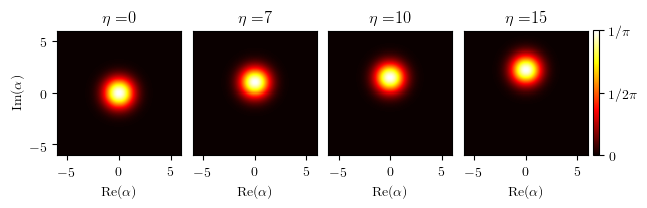

In [9]:
# Plot Qfunc
rc("text", usetex=true)
rc("font", family="serif")
pygui(false)

fig = figure(figsize=(7,2.1875))
# fig = figure()
# gs = gridspec.GridSpec(1, size(η_arr)[1])


for i in 1:size(η_arr)[1]
#     host = fig.add_subplot(gs[0,i])
    
    plt_index = 100 + size(η_arr)[1] * 10 + i
    host = fig.add_subplot(plt_index)
    colorz = host.imshow(qfunc_arr[i], cmap="hot", interpolation="nearest", extent=(-6,6,-6,6))
    
    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
#     host.set_xticks([-0.75, 0, 0.75])
    
    if i == 1
        ylabel(L"\mathrm{Im}(\alpha)")
        xlabel(L"\mathrm{Re}(\alpha)")
    else
        xlabel(L"\mathrm{Re}(\alpha)")
        yticks([], [])
    end
        
    colorbar_ticks = [0, 1/(2*π), 1/π]
    ticklabels = [L"0", L"1/2\pi", L"1/\pi"]

    if i != size(η_arr)[1]
        rez = fig.colorbar(cmap="hot", colorz, ticks=[], fraction=0.046, pad=0.04, filled=false, drawedges=true)
        rez.outline.set_color("white")
    else
        rez = fig.colorbar(cmap="hot", colorz, ticks=colorbar_ticks, fraction=0.046, pad=0.04)
        rez.set_ticklabels(ticklabels)
    end
    
        
end

subplots_adjust(hspace=0, wspace=0);
# tight_layout()

In [5]:
# Calculate order parameter

η_arr = [0:0.5:15;] .* ωr
bdr = 6
step = 0.1
len_half = bdr / step
xvec = [-bdr:step:bdr;]
yvec = [-bdr:step:bdr;]
order_param_arr = []

for i in 1:size(η_arr)[1]
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i]))) / 2, 1);
    husimi_q = qfunc(ptrace(ψ_states[1], 2), xvec, yvec)
    temp = abs(findmax(real.(husimi_q))[2][1] - (len_half + 1)) / len_half * bdr
    push!(order_param_arr, temp)
end

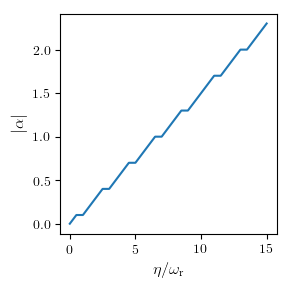

In [8]:
# Plot order parameter
rc("text", usetex=true)
rc("text.latex", preamble= "\\usepackage{amsmath}")
rc("font", family="serif")
pygui(false)

figure(figsize=(3,3))
plot(η_arr, order_param_arr)
xlabel(L"\eta / \omega_\text{r}", fontsize=12)
ylabel(L"|\alpha|", fontsize=12)
# xlim(0, 8)
tight_layout()
# title("Order parameter transversal");

As opposed to the transversal pump, there's no critical pump strength at which the order parameter rises quickly.

In [10]:
# Illustrate caution with cutoff

η = 40 .* ωr
cutoff_arr = [8, 16, 32, 64, 128]
probab_arr = []
N_arr = []
σ_sqr_arr = []
X_arr = []

xmin = 0
xmax = 1
Nsteps = 64

k = 2*π
ωr = 1

Δc = -10 * ωr
U0 = -1 * ωr


######
for N_cutoff in cutoff_arr
    # Bases
    b_position = PositionBasis(xmin, xmax, Nsteps)
    b_fock = FockBasis(N_cutoff)

    # Operators for atom
    p = momentum(b_position)

    # Operators for cavity
    a = destroy(b_fock) ⊗ one(b_position)
    ad = dagger(a)

    # Hamiltonian and calculate states
    potential = x -> U0*cos(k*x)^2
    H_int = (one(b_fock) ⊗ potentialoperator(b_position, potential))*ad*a
    H_kin = (one(b_fock) ⊗ p^2) / k^2
    H_cavity = -Δc*ad*a

    function H(η)
        H_kin + dense(H_int) + H_cavity + η*(a + ad)
    end;

    _, ψ_states = eigenstates((H(η) + dagger(H(η)))/2, 1)
    photon_dense = ptrace(ψ_states[1], 2)

    X = [0:1:N_cutoff;]
    push!(X_arr, X)
    probab = diag(photon_dense.data)
    N = real(expect(ad*a, ψ_states[1]))
    σ_sqr = real(sum(probab .* X.^2) - N^2)

    push!(probab_arr, probab)
    push!(N_arr, N)
    push!(σ_sqr_arr, σ_sqr)
end

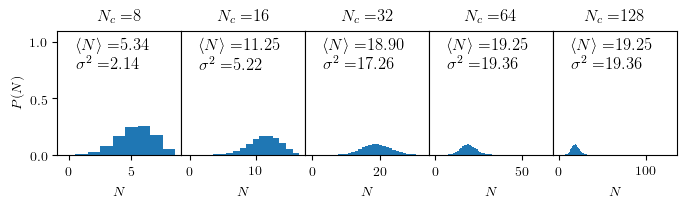

In [14]:
# Plot photon number
using PyCall

rc("text", usetex=true)
rc("font", family="serif")
pygui(false)

displace = [0.15, 0.15, 0.15, 0.15]

fig = figure(figsize=(7,2.1875))
# subplots(sharex=true)
for i in 1:size(cutoff_arr)[1]
    plt_index = 100 + size(cutoff_arr)[1]*10 + i
    host = fig.add_subplot(plt_index)
#     host.set_xlim(0, 10)
#     host.set_ylim(-0.0001, 0.0017)
    host.bar(X_arr[i], probab_arr[i], width=1)
#     host.set_xticks([0, 2.5, 5, 7.5])
    host.set_ylim(0, 1.1)
#     host.set_yticks([.25, .5, .75, 1])
    host.set_xlabel(L"N");
    
    if i == 1
        host.set_ylabel(L"P(N)")
    else
        yticks([], [])
    end
    
    if i == 4
#         host.set_xticks([0, 2.5, 5, 7.5, 10])
    end

    title_string = L"N_c =" * @sprintf("%d", cutoff_arr[i])
    title(title_string)
    
    textstr = L"\langle N \rangle=" * @sprintf("%.2f", real(N_arr[i])) * "\n" * L"\sigma^2=" * @sprintf("%.2f", σ_sqr_arr[i])
    host.text(0.15, 0.95, textstr, transform=host.transAxes, fontsize=12, verticalalignment="top")
end
tight_layout()
subplots_adjust(hspace=0, wspace=0);
# text(-10.5, -.305, L"N");